# TechNova Partners - Analyse du Churn RH

**Projet :** Identification des causes de démission et modélisation prédictive  
**Client :** TechNova Partners (ESN spécialisée en transformation digitale)

---

## Contexte du Projet

TechNova Partners fait face à un turnover élevé. L'objectif est de :

1. **Analyser** les données RH pour identifier les différences entre employés partis et restés
2. **Construire** un modèle de classification pour prédire les démissions
3. **Extraire** les causes potentielles via l'interprétation du modèle (SHAP)

**Sources de données :**

- `data/extrait_sirh.csv` - Informations RH (âge, salaire, poste, ancienneté...)
- `data/extrait_eval.csv` - Évaluations de performance
- `data/extrait_sondage.csv` - Sondage employés + **variable cible**

---

## Structure du Notebook

**Partie 1 : Exploration des Données**

- Chargement et compréhension des fichiers
- Fusion et création du dataset central
- Analyse exploratoire et visualisations

**Partie 2 : Feature Engineering**

- Préparation des features (X)
- Encodage des variables catégorielles
- Gestion des corrélations

**Partie 3 : Modélisation Baseline**

- Modèle Dummy (référence)
- Modèle linéaire
- Modèle non-linéaire (arbre)

**Partie 4 : Gestion du Déséquilibre**

- Stratification
- Class weights / Undersampling / Oversampling (SMOTE)
- Calibration de probabilité
- Validation croisée stratifiée

**Partie 5 : Optimisation et Interpretation**

- Fine-tuning des hyperparamètres
- Feature importance globale (SHAP, Permutation)
- Feature importance locale (SHAP Waterfall)

---


---

## 1. Importation des librairies


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # noqa: E402

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", "{:.2f}".format)

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

warnings.filterwarnings("ignore")

---

## 2. Chargement des données

Chargement des 3 fichiers CSV et examen de structure.


In [59]:
df_sirh = pd.read_csv("data/extrait_sirh.csv")
df_eval = pd.read_csv("data/extrait_eval.csv")
df_sondage = pd.read_csv("data/extrait_sondage.csv")

print(f"Fichier SIRH : {df_sirh.shape[0]} lignes, {df_sirh.shape[1]} colonnes")
print(f"Fichier Évaluations : {df_eval.shape[0]} lignes, {df_eval.shape[1]} colonnes")
print(f"Fichier Sondage : {df_sondage.shape[0]} lignes, {df_sondage.shape[1]} colonnes")

Fichier SIRH : 1470 lignes, 12 colonnes
Fichier Évaluations : 1470 lignes, 10 colonnes
Fichier Sondage : 1470 lignes, 12 colonnes


---

## 3. Exploration initiale de chaque fichier

Avant de fusionner, comprenons le contenu et la structure de chaque fichier.


### 3.1 Fichier SIRH (extrait_sirh.csv)


#### Aperçu des premières lignes

Visualisons les premières lignes pour comprendre la structure et le contenu.


In [60]:
df_sirh.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2


#### Structure et types de données

Analysons les types de colonnes, la mémoire utilisée et les valeurs non-nulles.


In [61]:
df_sirh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


#### Statistiques descriptives

Calculons les statistiques de base (moyenne, écart-type, min, max, quartiles) pour les variables numériques.


In [62]:
df_sirh.describe()

,id_employee,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,1024.87,36.92,6502.93,2.69,80.00,11.28,7.01,4.23
std,602.02,9.14,4707.96,2.50,0.00,7.78,6.13,3.62
min,1.00,18.00,1009.00,0.00,80.00,0.00,0.00,0.00
25%,491.25,30.00,2911.00,1.00,80.00,6.00,3.00,2.00
50%,1020.50,36.00,4919.00,2.00,80.00,10.00,5.00,3.00
75%,1555.75,43.00,8379.00,4.00,80.00,15.00,9.00,7.00
max,2068.00,60.00,19999.00,9.00,80.00,40.00,40.00,18.00


#### Analyse des variables catégorielles

Examinons les valeurs uniques et leur fréquence pour chaque variable catégorielle.


In [63]:
print("Valeurs uniques des colonnes catégorielles SIRH :")
for col in df_sirh.select_dtypes(include="object").columns:
    print(f"\n{col}: {df_sirh[col].nunique()} valeurs uniques")
    print(df_sirh[col].value_counts())

Valeurs uniques des colonnes catégorielles SIRH :

genre: 2 valeurs uniques
genre
M    882
F    588
Name: count, dtype: int64

statut_marital: 3 valeurs uniques
statut_marital
Marié(e)       673
Célibataire    470
Divorcé(e)     327
Name: count, dtype: int64

departement: 3 valeurs uniques
departement
Consulting             961
Commercial             446
Ressources Humaines     63
Name: count, dtype: int64

poste: 9 valeurs uniques
poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Représentant Commercial     83
Directeur Technique         80
Ressources Humaines         52
Name: count, dtype: int64


### 3.2 Fichier Évaluations (extrait_eval.csv)


#### Aperçu des premières lignes


In [64]:
df_eval.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %


#### Structure et types de données


In [65]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64(7), object(3)
memory usage:

#### Statistiques descriptives


In [66]:
print("Statistiques descriptives Evaluations (variables numeriques) :")
df_eval.describe()

Statistiques descriptives Evaluations (variables numeriques) :


,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,2.72,2.73,2.06,2.73,2.71,2.76,3.15
std,1.09,0.71,1.11,1.10,1.08,0.71,0.36
min,1.00,1.00,1.00,1.00,1.00,1.00,3.00
25%,2.00,2.00,1.00,2.00,2.00,2.00,3.00
50%,3.00,3.00,2.00,3.00,3.00,3.00,3.00
75%,4.00,3.00,3.00,4.00,4.00,3.00,3.00
max,4.00,4.00,5.00,4.00,4.00,4.00,4.00


#### Analyse des variables catégorielles


In [67]:
# Valeurs uniques des colonnes catégorielles
print("Valeurs uniques des colonnes catégorielles Evaluations :")
for col in df_eval.select_dtypes(include="object").columns:
    print(f"\n{col}: {df_eval[col].nunique()} valeurs uniques")
    print(df_eval[col].value_counts())

Valeurs uniques des colonnes catégorielles Evaluations :

eval_number: 1470 valeurs uniques
eval_number
E_1       1
E_2       1
E_4       1
E_5       1
E_7       1
         ..
E_2061    1
E_2062    1
E_2064    1
E_2065    1
E_2068    1
Name: count, Length: 1470, dtype: int64

heure_supplementaires: 2 valeurs uniques
heure_supplementaires
Non    1054
Oui     416
Name: count, dtype: int64

augementation_salaire_precedente: 15 valeurs uniques
augementation_salaire_precedente
11 %    210
13 %    209
14 %    201
12 %    198
15 %    101
18 %     89
17 %     82
16 %     78
19 %     76
22 %     56
20 %     55
21 %     48
23 %     28
24 %     21
25 %     18
Name: count, dtype: int64


### 3.3 Fichier Sondage (extrait_sondage.csv)


#### Aperçu des premières lignes


In [68]:
df_sondage.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


#### Structure et types de données


In [69]:
df_sondage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

#### Statistiques descriptives


In [70]:
df_sondage.describe()

,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,0.79,2.80,1.00,1024.87,9.19,2.91,2.19,4.12
std,0.85,1.29,0.00,602.02,8.11,1.02,3.22,3.57
min,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00
25%,0.00,2.00,1.00,491.25,2.00,2.00,0.00,2.00
50%,1.00,3.00,1.00,1020.50,7.00,3.00,1.00,3.00
75%,1.00,3.00,1.00,1555.75,14.00,4.00,3.00,7.00
max,3.00,6.00,1.00,2068.00,29.00,5.00,15.00,17.00


#### Analyse des variables catégorielles


In [71]:
for col in df_sondage.select_dtypes(include="object").columns:
    print(f"\n{col}: {df_sondage[col].nunique()} valeurs uniques")
    print(df_sondage[col].value_counts())


a_quitte_l_entreprise: 2 valeurs uniques
a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64

domaine_etude: 6 valeurs uniques
domaine_etude
Infra & Cloud              606
Transformation Digitale    464
Marketing                  159
Entrepreunariat            132
Autre                       82
Ressources Humaines         27
Name: count, dtype: int64

ayant_enfants: 1 valeurs uniques
ayant_enfants
Y    1470
Name: count, dtype: int64

frequence_deplacement: 3 valeurs uniques
frequence_deplacement
Occasionnel    1043
Frequent        277
Aucun           150
Name: count, dtype: int64


---

## 4. Identification des clés de jointure

Pour fusionner les 3 fichiers, nous devons identifier les colonnes qui permettent de faire le lien entre eux.


#### Analyse des colonnes identifiantes

Examinons les colonnes qui nous permettront de faire les jointures entre fichiers.


In [72]:
print("Colonnes SIRH :")
print(df_sirh.columns.tolist())
print(
    f"\nClé potentielle 'id_employee' : {df_sirh['id_employee'].nunique()} valeurs uniques sur {len(df_sirh)} lignes"
)

print("\n" + "-" * 60)
print("\nColonnes Évaluations :")
print(df_eval.columns.tolist())
print(
    f"\nClé potentielle 'eval_number' : {df_eval['eval_number'].nunique()} valeurs uniques sur {len(df_eval)} lignes"
)

print("\n" + "-" * 60)
print("\nColonnes Sondage :")
print(df_sondage.columns.tolist())
print(
    f"\nClé potentielle 'code_sondage' : {df_sondage['code_sondage'].nunique()} valeurs uniques sur {len(df_sondage)} lignes"
)

Colonnes SIRH :
['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel']

Clé potentielle 'id_employee' : 1470 valeurs uniques sur 1470 lignes

------------------------------------------------------------

Colonnes Évaluations :
['satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente']

Clé potentielle 'eval_number' : 1470 valeurs uniques sur 1470 lignes

------------------------------------------------------------

Colonnes Sondage :
['a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite

In [73]:
# Analysons le format des clés pour comprendre comment les relier
print("Exemples de clés :")
print(f"\nSIRH - id_employee (premiers) : {df_sirh['id_employee'].head(10).tolist()}")
print(f"\nEval - eval_number (premiers) : {df_eval['eval_number'].head(10).tolist()}")
print(
    f"\nSondage - code_sondage (premiers) : {df_sondage['code_sondage'].head(10).tolist()}"
)

Exemples de clés :

SIRH - id_employee (premiers) : [1, 2, 4, 5, 7, 8, 10, 11, 12, 13]

Eval - eval_number (premiers) : ['E_1', 'E_2', 'E_4', 'E_5', 'E_7', 'E_8', 'E_10', 'E_11', 'E_12', 'E_13']

Sondage - code_sondage (premiers) : [1, 2, 4, 5, 7, 8, 10, 11, 12, 13]


#### Analyse du format des clés

Regardons de plus près comment sont structurées ces clés.


In [74]:
print("Comparaison du nombre de lignes :")
print(f"  - SIRH : {len(df_sirh)} lignes")
print(f"  - Évaluations : {len(df_eval)} lignes")
print(f"  - Sondage : {len(df_sondage)} lignes")

# Si tous les fichiers ont le même nombre de lignes,
# ils correspondent probablement aux mêmes employés

Comparaison du nombre de lignes :
  - SIRH : 1470 lignes
  - Évaluations : 1470 lignes
  - Sondage : 1470 lignes


#### Vérification de la cohérence des données

Comparons le nombre de lignes pour détecter d'éventuels problèmes.


In [75]:
print("Analyse de l'ordre et de la correspondance des lignes :\n")

# Hypothèse : si tous ont le même nombre de lignes dans le même ordre,
# les employés sont peut-être déjà alignés par index

# Vérifions s'il y a des colonnes communes
print("Colonnes communes entre les fichiers :")
sirh_cols = set(df_sirh.columns)
eval_cols = set(df_eval.columns)
sondage_cols = set(df_sondage.columns)

print(f"\nSIRH ∩ Évaluations : {sirh_cols.intersection(eval_cols)}")
print(f"SIRH ∩ Sondage : {sirh_cols.intersection(sondage_cols)}")
print(f"Évaluations ∩ Sondage : {eval_cols.intersection(sondage_cols)}")


Analyse de l'ordre et de la correspondance des lignes :

Colonnes communes entre les fichiers :

SIRH ∩ Évaluations : set()
SIRH ∩ Sondage : set()
Évaluations ∩ Sondage : set()


#### Conclusion : Fusion par index

**Résultat attendu :** Aucune colonne commune (set() vide partout).

**Pourquoi ?** Chaque fichier a des colonnes **uniques** :

- SIRH → infos administratives (id_employee, ancienneté, salaire...)
- Évaluations → métriques performance (eval_number, satisfaction_manager, note_autonomie...)
- Sondage → perception employé (code_sondage, equilibre_vie_pro_perso, niveau_stress...)

**Stratégie de fusion :** Comme les 3 fichiers ont le **même nombre de lignes (1470)** et que les indices correspondent (id_employee=1 ↔ eval_number="E_1" ↔ code_sondage=1), nous pouvons effectuer une **concaténation horizontale par index** avec `pd.concat(..., axis=1)`.

Aucune jointure SQL n'est nécessaire, Les lignes sont déjà alignées.


#### Recherche de colonnes communes

Vérifions s'il existe des colonnes partagées entre les fichiers.


In [76]:
# Analysons la structure des colonnes "clés"
print("Analyse détaillée des colonnes identifiantes :\n")

# SIRH
print("FICHIER SIRH - Colonne 'id_employee'")
print(f"Type de données : {df_sirh['id_employee'].dtype}")
print(f"Valeurs uniques : {df_sirh['id_employee'].nunique()}")
print(f"Total de lignes : {len(df_sirh)}")
print(f"Valeurs manquantes : {df_sirh['id_employee'].isna().sum()}")
print(f"Doublons : {df_sirh['id_employee'].duplicated().sum()}")
print(f"\nExemples : {df_sirh['id_employee'].head(5).tolist()}")

# Évaluations
print("FICHIER ÉVALUATIONS - Colonne 'eval_number'")
print(f"Type de données : {df_eval['eval_number'].dtype}")
print(f"Valeurs uniques : {df_eval['eval_number'].nunique()}")
print(f"Total de lignes : {len(df_eval)}")
print(f"Valeurs manquantes : {df_eval['eval_number'].isna().sum()}")
print(f"Doublons : {df_eval['eval_number'].duplicated().sum()}")
print(f"\nExemples : {df_eval['eval_number'].head(5).tolist()}")

# Sondage
print("FICHIER SONDAGE - Colonne 'code_sondage'")
print(f"Type de données : {df_sondage['code_sondage'].dtype}")
print(f"Valeurs uniques : {df_sondage['code_sondage'].nunique()}")
print(f"Total de lignes : {len(df_sondage)}")
print(f"Valeurs manquantes : {df_sondage['code_sondage'].isna().sum()}")
print(f"Doublons : {df_sondage['code_sondage'].duplicated().sum()}")
print(f"\nExemples : {df_sondage['code_sondage'].head(5).tolist()}")

Analyse détaillée des colonnes identifiantes :

FICHIER SIRH - Colonne 'id_employee'
Type de données : int64
Valeurs uniques : 1470
Total de lignes : 1470
Valeurs manquantes : 0
Doublons : 0

Exemples : [1, 2, 4, 5, 7]
FICHIER ÉVALUATIONS - Colonne 'eval_number'
Type de données : object
Valeurs uniques : 1470
Total de lignes : 1470
Valeurs manquantes : 0
Doublons : 0

Exemples : ['E_1', 'E_2', 'E_4', 'E_5', 'E_7']
FICHIER SONDAGE - Colonne 'code_sondage'
Type de données : int64
Valeurs uniques : 1470
Total de lignes : 1470
Valeurs manquantes : 0
Doublons : 0

Exemples : [1, 2, 4, 5, 7]


#### Analyse détaillée des clés de jointure

Explorons en détail chaque colonne identifiante pour comprendre leur structure.


In [77]:
# Vérifions si les clés peuvent être liées entre elles
print("Recherche de correspondances potentielles entre les clés :\n")

# Testons si une partie de la clé correspond entre fichiers
# Par exemple, si id_employee = "EMP_001" et eval_number contient "001"

print("Premières valeurs de chaque clé pour comparaison visuelle :")
comparison_df = pd.DataFrame(
    {
        "id_employee": df_sirh["id_employee"].head(10),
        "eval_number": df_eval["eval_number"].head(10),
        "code_sondage": df_sondage["code_sondage"].head(10),
    }
)
comparison_df

Recherche de correspondances potentielles entre les clés :

Premières valeurs de chaque clé pour comparaison visuelle :


,id_employee,eval_number,code_sondage
0,1,E_1,1
1,2,E_2,2
2,4,E_4,4
3,5,E_5,5
4,7,E_7,7
5,8,E_8,8
6,10,E_10,10
7,11,E_11,11
8,12,E_12,12
9,13,E_13,13


---

## 5. Fusion des données

Les 3 fichiers ont le même nombre de lignes (1470) et les clés correspondent (id*employee = code_sondage, eval_number = "E*" + id).
Nous allons les fusionner par concaténation horizontale.


#### Création du DataFrame central

Fusion des 3 fichiers par concaténation horizontale (axis=1).


In [78]:
df_merged = pd.concat([df_sirh, df_eval, df_sondage], axis=1)

print("DataFrame fusionné créé :")
print(f"  - {df_merged.shape[0]} lignes")
print(f"  - {df_merged.shape[1]} colonnes")
print(f"\nColonnes : {df_merged.columns.tolist()}")

DataFrame fusionné créé :
  - 1470 lignes
  - 34 colonnes

Colonnes : ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']


#### Gestion des colonnes dupliquées

Vérification et suppression des éventuelles colonnes en double.


In [79]:
# Vérification des colonnes dupliquées
duplicated_cols = df_merged.columns[df_merged.columns.duplicated()].tolist()

if duplicated_cols:
    print(f"{len(duplicated_cols)} colonne(s) dupliquée(s) détectée(s) :")
    for col in duplicated_cols:
        print(f"  - {col}")

    # Suppression des doublons (on garde la première occurrence)
    df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
    print("\nColonnes dupliquées supprimées")
    print(f"Nouvelles dimensions : {df_merged.shape}")
else:
    print("Aucune colonne dupliquée détectée")

Aucune colonne dupliquée détectée


#### Aperçu du DataFrame central

Visualisation des premières lignes du dataset fusionné.


In [80]:
df_merged.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,E_1,3,Oui,11 %,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,E_2,4,Non,23 %,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,E_4,3,Oui,15 %,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,E_5,3,Oui,11 %,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,E_7,3,Non,12 %,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


#### Structure du DataFrame fusionné

Informations sur les types de données et la mémoire.


In [81]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_travailless                  1470 non-null   int64 
 9   annee_experience_totale                    1470 non-null   int64 
 10  annees_dans_l_entreprise            

#### Analyse de la variable cible

Distribution de `a_quitte_l_entreprise` - la variable à prédire.


Variable cible - 'a_quitte_l_entreprise' :
Type : object

Distribution :
a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64

Proportions (%) :
a_quitte_l_entreprise
Non   83.88
Oui   16.12
Name: proportion, dtype: float64


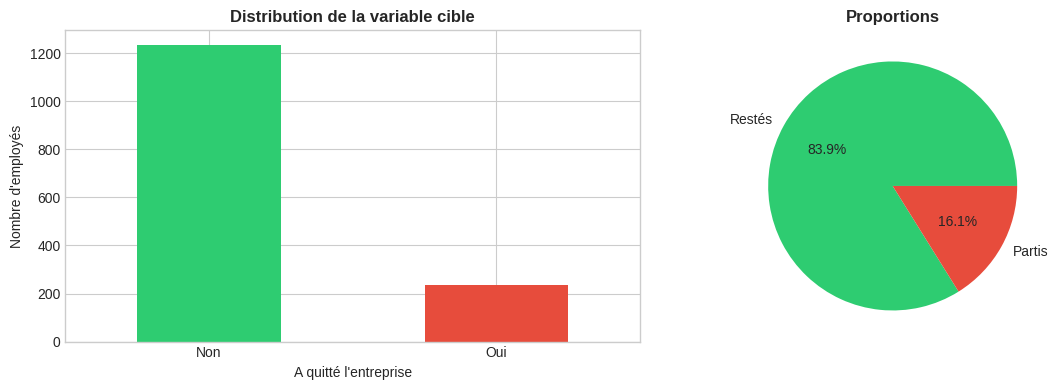

OBSERVATION CRITIQUE : Déséquilibre des classes !
     → À gérer en modélisation (stratification, class_weights, SMOTE)


In [82]:
print("Variable cible - 'a_quitte_l_entreprise' :")
print(f"Type : {df_merged['a_quitte_l_entreprise'].dtype}")
print("\nDistribution :")
print(df_merged["a_quitte_l_entreprise"].value_counts())
print("\nProportions (%) :")
print((df_merged["a_quitte_l_entreprise"].value_counts(normalize=True) * 100).round(2))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Comptage
df_merged["a_quitte_l_entreprise"].value_counts().plot(
    kind="bar", ax=ax[0], color=["#2ecc71", "#e74c3c"]
)
ax[0].set_title("Distribution de la variable cible", fontsize=12, fontweight="bold")
ax[0].set_xlabel("A quitté l'entreprise")
ax[0].set_ylabel("Nombre d'employés")
ax[0].set_xticklabels(["Non", "Oui"], rotation=0)

# Proportions
df_merged["a_quitte_l_entreprise"].value_counts().plot(
    kind="pie",
    ax=ax[1],
    autopct="%1.1f%%",
    colors=["#2ecc71", "#e74c3c"],
    labels=["Restés", "Partis"],
)
ax[1].set_title("Proportions", fontsize=12, fontweight="bold")
ax[1].set_ylabel("")

plt.tight_layout()
plt.show()

print("OBSERVATION CRITIQUE : Déséquilibre des classes !")
print("     → À gérer en modélisation (stratification, class_weights, SMOTE)")


#### Synthèse : Variable cible

- **84% restés** vs **16% partis** → Ratio 5:1
- Déséquilibre à gérer : stratification, class_weight, resampling, calibration
- Accuracy insuffisante comme métrique (84% sans rien faire)


---

## 6. Vue d'ensemble du dataset central

Avant de comparer les employés partis vs restés, vérifions la qualité et la structure des données :

- Valeurs manquantes
- Types de colonnes (numériques vs catégorielles)
- Colonnes identifiantes à exclure de l'analyse


#### Analyse des valeurs manquantes

Vérifions s'il y a des données manquantes dans le dataset fusionné.


In [83]:
# Analyse des valeurs manquantes
print("Analyse des valeurs manquantes :\n")

missing_values = df_merged.isnull().sum()
missing_pct = (df_merged.isnull().sum() / len(df_merged) * 100).round(2)

missing_df = pd.DataFrame(
    {"Valeurs manquantes": missing_values, "Pourcentage (%)": missing_pct}
)

# Afficher seulement les colonnes avec des valeurs manquantes
missing_with_values = missing_df[missing_df["Valeurs manquantes"] > 0]

if len(missing_with_values) > 0:
    print(f"{len(missing_with_values)} colonne(s) avec des valeurs manquantes :")
    print(missing_with_values.sort_values("Pourcentage (%)", ascending=False))
else:
    print("Aucune valeur manquante dans le dataset !")
    print(f"   → {df_merged.shape[0]} lignes × {df_merged.shape[1]} colonnes complètes")

Analyse des valeurs manquantes :

Aucune valeur manquante dans le dataset !
   → 1470 lignes × 34 colonnes complètes


#### Classification des colonnes par type

Identifions les colonnes numériques et catégorielles pour orienter l'analyse exploratoire.


In [84]:
print("Classification des colonnes par type :\n")

# Colonnes identifiantes (à exclure de l'analyse)
id_cols = ["id_employee", "eval_number", "code_sondage"]

# Variable cible
target_col = "a_quitte_l_entreprise"

# Colonnes numériques (excluant les IDs)
numeric_cols = df_merged.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in id_cols + [target_col]]

# Colonnes catégorielles
categorical_cols = df_merged.select_dtypes(include=["object"]).columns.tolist()
categorical_cols = [
    col for col in categorical_cols if col not in id_cols + [target_col]
]

print(f"Colonnes identifiantes ({len(id_cols)}) - À EXCLURE :")
print(f"   {id_cols}\n")

print("Variable cible :")
print(f"   {target_col}\n")

print(f"Colonnes numériques ({len(numeric_cols)}) :")
print(f"   {numeric_cols}\n")

print(f"Colonnes catégorielles ({len(categorical_cols)}) :")
print(f"   {categorical_cols}")

print(f"Total features analysables : {len(numeric_cols) + len(categorical_cols)}")

Classification des colonnes par type :

Colonnes identifiantes (3) - À EXCLURE :
   ['id_employee', 'eval_number', 'code_sondage']

Variable cible :
   a_quitte_l_entreprise

Colonnes numériques (21) :
   ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']

Colonnes catégorielles (9) :
   ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'augementation_salaire_precedente', 'domaine_etude', '

#### Résumé structuré du dataset

Tableau récapitulatif avec le type, les valeurs uniques et des exemples pour chaque colonne.


In [85]:
summary_data = []

for col in df_merged.columns:
    if col in id_cols:
        category = "Identifiant"
    elif col == target_col:
        category = "Cible"
    elif col in numeric_cols:
        category = "Numérique"
    else:
        category = "Catégorielle"

    summary_data.append(
        {
            "Colonne": col,
            "Catégorie": category,
            "Type": str(df_merged[col].dtype),
            "Valeurs uniques": df_merged[col].nunique(),
            "Exemple": str(df_merged[col].iloc[0])[:30],
        }
    )

summary_df = pd.DataFrame(summary_data)
summary_df

,Colonne,Catégorie,Type,Valeurs uniques,Exemple
0,id_employee,Identifiant,int64,1470,1
1,age,Numérique,int64,43,41
2,genre,Catégorielle,object,2,F
3,revenu_mensuel,Numérique,int64,1349,5993
4,statut_marital,Catégorielle,object,3,Célibataire
5,departement,Catégorielle,object,3,Commercial
6,poste,Catégorielle,object,9,Cadre Commercial
7,nombre_experiences_precedentes,Numérique,int64,10,8
8,nombre_heures_travailless,Numérique,int64,1,80
9,annee_experience_totale,Numérique,int64,40,8


---

## 7. Analyse exploratoire comparative : Partis vs Restés

Objectif principal de cette section : **identifier les différences clés** entre les employés ayant quitté l'entreprise et ceux qui y sont restés.

Nous utiliserons **Plotly** pour des graphiques interactifs.


#### Import de Plotly et préparation des données

Configuration de Plotly et création d'une colonne lisible pour la variable cible.


In [86]:
import plotly.express as px

df_merged["statut"] = df_merged["a_quitte_l_entreprise"].map(
    {"Oui": "Parti", "Non": "Resté"}
)

colors = {"Resté": "#2ecc71", "Parti": "#e74c3c"}

print(f"   Distribution : {df_merged['statut'].value_counts().to_dict()}")

   Distribution : {'Resté': 1233, 'Parti': 237}


### 7.1 Analyse des variables numériques

Comparons les **moyennes** des variables numériques entre les employés partis et restés avec un graphique unique et lisible.


#### Différences relatives des moyennes (Partis vs Restés)

Un seul graphique montrant la différence en pourcentage pour chaque variable.


In [87]:
# Calcul des moyennes par statut
means_parti = df_merged[df_merged["statut"] == "Parti"][numeric_cols].mean()
means_reste = df_merged[df_merged["statut"] == "Resté"][numeric_cols].mean()

# Calcul de la différence relative en %
diff_pct = ((means_parti - means_reste) / means_reste * 100).round(1)

# Créer le DataFrame pour le graphique
diff_df = pd.DataFrame(
    {"Variable": diff_pct.index, "Différence (%)": diff_pct.values}
).sort_values("Différence (%)", key=abs, ascending=True)

fig = px.bar(
    diff_df,
    x="Différence (%)",
    y="Variable",
    orientation="h",
    title="Différence relative des moyennes : Partis vs Restés",
    color="Différence (%)",
    color_continuous_scale=["#e74c3c", "#f5f5f5", "#2ecc71"],
    color_continuous_midpoint=0,
)

fig.add_vline(x=0, line_color="black", line_width=2)
fig.update_layout(
    height=600,
    xaxis_title="Différence relative (%)",
    yaxis_title="",
    coloraxis_colorbar_title="Diff (%)",
)

fig.show()

#### Comment lire ce graphique ?

Chaque barre montre **de combien de %** les employés qui partent diffèrent de ceux qui restent **pour cette variable**.

| Variable                    | Diff   | Signification concrète                               |
| --------------------------- | ------ | ---------------------------------------------------- |
| `revenu_mensuel`            | -29.9% | Ceux qui partent gagnent **moins d'argent**          |
| `annees_dans_l_entreprise`  | -30.4% | Ceux qui partent ont **moins d'années** d'ancienneté |
| `distance_domicile_travail` | +19.3% | Ceux qui partent habitent à **plus de kilomètres**   |

**En résumé :**

- Barre rouge (négative) : Ceux qui partent ont une valeur **plus basse** pour cette variable
- Barre verte (positive) : Ceux qui partent ont une valeur **plus haute** pour cette variable
- Proche de 0 : Pas de différence entre les deux groupes


#### Observations : Variables numériques

**Principales différences observées :**

| Variable                      | Différence | Observation                          |
| ----------------------------- | ---------- | ------------------------------------ |
| `nombre_participation_pee`    | -37.6%     | Participation PEE plus faible        |
| `annees_dans_le_poste_actuel` | -35.3%     | Ancienneté dans le poste plus faible |
| `revenu_mensuel`              | -29.9%     | Salaire plus bas                     |
| `distance_domicile_travail`   | +19.3%     | Distance plus grande                 |

**Note :** Ce sont des observations descriptives. Le modèle confirmera l'importance réelle de chaque variable.


#### Tableau récapitulatif des statistiques

Détail des moyennes et médianes pour chaque groupe.


In [88]:
# Tableau récapitulatif plus robuste
stats_parti = df_merged[df_merged["statut"] == "Parti"][numeric_cols].agg(
    ["mean", "median"]
)
stats_reste = df_merged[df_merged["statut"] == "Resté"][numeric_cols].agg(
    ["mean", "median"]
)

comparison_stats = pd.DataFrame(
    {
        "Parti_moyenne": stats_parti.loc["mean"],
        "Parti_médiane": stats_parti.loc["median"],
        "Resté_moyenne": stats_reste.loc["mean"],
        "Resté_médiane": stats_reste.loc["median"],
    }
)

# Calculer la différence relative
comparison_stats["Diff_%"] = (
    (comparison_stats["Parti_moyenne"] - comparison_stats["Resté_moyenne"])
    / comparison_stats["Resté_moyenne"]
    * 100
).round(1)

# Trier par différence absolue
comparison_stats = comparison_stats.sort_values("Diff_%", key=abs, ascending=False)

print("Statistiques comparatives (triées par |différence|) :\n")
comparison_stats.round(2)

Statistiques comparatives (triées par |différence|) :



,Parti_moyenne,Parti_médiane,Resté_moyenne,Resté_médiane,Diff_%
nombre_participation_pee,0.53,0.00,0.85,1.00,-37.60
annees_dans_le_poste_actuel,2.90,2.00,4.48,3.00,-35.30
annes_sous_responsable_actuel,2.85,2.00,4.37,3.00,-34.70
annee_experience_totale,8.24,7.00,11.86,10.00,-30.50
annees_dans_l_entreprise,5.13,3.00,7.37,6.00,-30.40
revenu_mensuel,4787.09,3202.00,6832.74,5204.00,-29.90
niveau_hierarchique_poste,1.64,1.00,2.15,2.00,-23.70
distance_domicile_travail,10.63,9.00,8.92,7.00,19.30
annees_depuis_la_derniere_promotion,1.95,1.00,2.23,1.00,-12.90
nombre_experiences_precedentes,2.94,1.00,2.65,2.00,11.20


### 7.2 Analyse des variables catégorielles

Visualisons le taux de churn pour chaque modalité de toutes les variables catégorielles.


#### Taux de churn par modalité

Graphique en barres horizontales montrant le taux de départ pour chaque modalité. La ligne rouge = taux moyen global (~16%).


In [89]:
# Calcul du taux de churn pour chaque modalité de chaque variable catégorielle
churn_data = []

for col in categorical_cols:
    for modalite in df_merged[col].unique():
        subset = df_merged[df_merged[col] == modalite]
        taux = (subset["a_quitte_l_entreprise"] == "Oui").mean() * 100
        effectif = len(subset)
        churn_data.append(
            {
                "Variable": col,
                "Modalité": str(modalite),
                "Taux_churn_%": round(taux, 1),
                "Effectif": effectif,
            }
        )

churn_df = pd.DataFrame(churn_data)

# Trier par taux de churn décroissant
churn_df = churn_df.sort_values("Taux_churn_%", ascending=True)

# Créer un label combiné pour l'axe Y
churn_df["Label"] = churn_df["Variable"] + " : " + churn_df["Modalité"]

# Taux global pour référence
taux_global = (df_merged["a_quitte_l_entreprise"] == "Oui").mean() * 100

fig = px.bar(
    churn_df,
    x="Taux_churn_%",
    y="Label",
    orientation="h",
    title="Taux de churn par modalité (toutes variables catégorielles)",
    color="Taux_churn_%",
    color_continuous_scale=["#2ecc71", "#f39c12", "#e74c3c"],
    hover_data=["Variable", "Modalité", "Effectif"],
    labels={"Taux_churn_%": "Taux de churn (%)", "Label": ""},
)

# Ligne de référence (taux global)
fig.add_vline(
    x=taux_global,
    line_dash="dash",
    line_color="red",
    line_width=2,
    annotation_text=f"Moyenne: {taux_global:.1f}%",
    annotation_position="top",
)

fig.update_layout(
    height=max(600, len(churn_df) * 25),
    xaxis_title="Taux de churn (%)",
    yaxis_title="",
    showlegend=False,
)

fig.show()

print(
    "\nLecture : Les barres a DROITE de la ligne rouge ont un taux de churn SUPERIEUR a la moyenne."
)


Lecture : Les barres a DROITE de la ligne rouge ont un taux de churn SUPERIEUR a la moyenne.


#### Observations : Variables catégorielles

**Taux de churn élevé :** Représentant Commercial (39.8%), heures sup Oui (30.5%), Célibataire (25.5%)

**Taux de churn faible :** Directeur Technique (2.5%), Manager (6.9%), heures sup Non (10.4%)

**Facteurs à explorer :** heures sup, poste, statut marital, déplacements.


---

### 7.3 Observations préliminaires

**Variables à explorer dans le modèle :**

- Numériques : `nombre_participation_pee`, `annees_dans_le_poste_actuel`, `revenu_mensuel`
- Catégorielles : `heure_supplementaires`, `poste`, `statut_marital`

**Attention :**

- Déséquilibre 84%/16% : stratification + gestion du déséquilibre nécessaire
- Ces observations sont **descriptives** : le modèle validera quelles variables sont réellement prédictives


---

# Partie 2 : Feature Engineering

Dans cette partie, nous allons :

1. **Nettoyer les donnees** : doublons, outliers, colonnes inutiles
2. **Analyser les correlations** : matrice de Pearson, suppression des variables trop correlees
3. **Encoder les variables categorielles** : OneHotEncoder pour les modeles
4. **Creer X et y** : preparation finale pour la modelisation


## 8. Nettoyage des donnees

### 8.1 Verification des doublons


In [90]:
print(f"  Nombre de lignes dupliquees : {df_merged.duplicated().sum()}")
print(f"\nDoublons sur 'id_employee' : {df_merged['id_employee'].duplicated().sum()}")

  Nombre de lignes dupliquees : 0

Doublons sur 'id_employee' : 0


### 8.2 Detection des outliers (methode IQR)

**Qu'est-ce que la methode IQR (Interquartile Range) ?**

L'IQR est une methode statistique robuste pour detecter les valeurs aberrantes :

**Calcul des bornes :**

- Borne inferieure = Q1 - 1.5 x IQR
- Borne superieure = Q3 + 1.5 x IQR

Toute valeur en dehors de ces bornes est consideree comme un **outlier**.

**Pourquoi IQR plutot que Z-score ?**

- IQR est base sur les **quartiles** (pas la moyenne)
- Donc **insensible aux valeurs extremes** elles-memes
- Plus adapte aux distributions non-normales


In [91]:
# Detection des outliers avec la methode IQR (Interquartile Range)
def detect_outliers_iqr(df, columns):
    """Detecte les outliers pour chaque colonne numerique avec la methode IQR."""
    outliers_summary = []

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        n_outliers = len(outliers)
        pct_outliers = (n_outliers / len(df)) * 100

        if n_outliers > 0:
            outliers_summary.append(
                {
                    "Variable": col,
                    "Nb outliers": n_outliers,
                    "% outliers": round(pct_outliers, 1),
                    "Borne inf": round(lower_bound, 2),
                    "Borne sup": round(upper_bound, 2),
                    "Min reel": round(df[col].min(), 2),
                    "Max reel": round(df[col].max(), 2),
                }
            )

    return pd.DataFrame(outliers_summary)


# Exclure les colonnes ID et la cible pour l'analyse des outliers
cols_to_check = [
    col
    for col in numeric_cols
    if col not in ["id_employee", "eval_number", "code_sondage"]
]
outliers_df = detect_outliers_iqr(df_merged, cols_to_check)

print(f"Variables avec outliers : {len(outliers_df)} / {len(cols_to_check)}")
print()
if len(outliers_df) > 0:
    display(outliers_df.sort_values("% outliers", ascending=False))

Variables avec outliers : 10 / 21



,Variable,Nb outliers,% outliers,Borne inf,Borne sup,Min reel,Max reel
7,nb_formations_suivies,238,16.20,0.50,4.50,0,6
5,note_evaluation_actuelle,226,15.40,3.00,3.00,3,4
0,revenu_mensuel,114,7.80,-5291.00,16581.00,1009,19999
8,annees_depuis_la_derniere_promotion,107,7.30,-4.50,7.50,0,15
3,annees_dans_l_entreprise,104,7.10,-6.00,18.00,0,40
6,nombre_participation_pee,85,5.80,-1.50,2.50,0,3
2,annee_experience_totale,63,4.30,-7.50,28.50,0,40
1,nombre_experiences_precedentes,52,3.50,-3.50,8.50,0,9
4,annees_dans_le_poste_actuel,21,1.40,-5.50,14.50,0,18
9,annes_sous_responsable_actuel,14,1.00,-5.50,14.50,0,17


**Decision sur les outliers :**

Les outliers detectes sont des valeurs coherentes dans un contexte RH :

- **Revenus eleves** : salaires de cadres superieurs (jusqu'a 19 999 EUR)
- **Anciennete elevee** : employes fideles (jusqu'a 40 ans)
- **Formations** : 6 formations maximum, valeur plausible

Ces valeurs ne sont pas des erreurs de saisie mais des cas legitimes. Nous les **conservons** car :

1. Les modeles tree-based (Random Forest, XGBoost) gerent bien les outliers
2. Ces profils extremes peuvent etre pertinents pour predire le churn


### 8.3 Identification des colonnes a supprimer

**Pourquoi supprimer certaines colonnes ?**

1. **Colonnes ID** (id_employee, eval_number, code_sondage)
   - Ce sont des identifiants uniques (1, 2, 3...)
   - Aucune valeur predictive : le modele ne peut pas apprendre que "employe 42" part plus souvent

2. **Colonnes a variance nulle**
   - Une colonne avec la **meme valeur pour tous** (ex: `nombre_heures_travailless = 80` pour tout le monde)
   - Aucune information discriminante : impossible de differencier partis vs restes

3. **Colonnes redondantes**
   - `a_quitte_l_entreprise` et `statut` contiennent la meme information que notre cible
   - Les garder = **data leakage** (le modele "triche")


In [92]:
print("Colonnes actuelles du dataset :")
print(df_merged.columns.tolist())

id_columns = ["id_employee", "eval_number", "code_sondage"]

target_column = "depart"

# Colonnes a variance nulle ou quasi-nulle
print("\n" + "-" * 60)
print("\nVerification des colonnes a faible variance :")
for col in df_merged.columns:
    unique_ratio = df_merged[col].nunique() / len(df_merged)
    if df_merged[col].nunique() <= 2 and col != target_column:
        print(
            f"  {col} : {df_merged[col].nunique()} valeurs uniques -> {df_merged[col].value_counts().to_dict()}"
        )

Colonnes actuelles du dataset :
['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'statut']

------------------------------------------------------------

Verification des colon

In [93]:
columns_to_drop = {
    # Colonnes ID (pas de valeur predictive)
    "id_employee": "Identifiant unique - pas de valeur predictive",
    "eval_number": "Identifiant evaluation - pas de valeur predictive",
    "code_sondage": "Identifiant sondage - pas de valeur predictive",
    # Colonnes a variance nulle (meme valeur pour tous)
    "nombre_heures_travailless": "Variance nulle - toujours 80",
    "nombre_employee_sous_responsabilite": "Variance nulle - toujours 1",
    "ayant_enfants": "Variance nulle - toujours Y",
    # Colonne redondante avec la cible
    "a_quitte_l_entreprise": 'Redondante avec "statut" (variable cible)',
    "statut": 'Redondante - nous utiliserons "depart" comme cible binaire',
}

print("Colonnes a supprimer :")
for col, reason in columns_to_drop.items():
    print(f"  - {col}: {reason}")

print(f"\nTotal : {len(columns_to_drop)} colonnes a supprimer")

Colonnes a supprimer :
  - id_employee: Identifiant unique - pas de valeur predictive
  - eval_number: Identifiant evaluation - pas de valeur predictive
  - code_sondage: Identifiant sondage - pas de valeur predictive
  - nombre_heures_travailless: Variance nulle - toujours 80
  - nombre_employee_sous_responsabilite: Variance nulle - toujours 1
  - ayant_enfants: Variance nulle - toujours Y
  - a_quitte_l_entreprise: Redondante avec "statut" (variable cible)
  - statut: Redondante - nous utiliserons "depart" comme cible binaire

Total : 8 colonnes a supprimer


In [94]:
# Creation du DataFrame nettoye
df_clean = df_merged.copy()

# Creation de la variable cible binaire 'depart' (0 = Reste, 1 = Churn)
df_clean["depart"] = (df_clean["statut"] == "Parti").astype(int)

# Suppression des colonnes identifiees
df_clean = df_clean.drop(columns=list(columns_to_drop.keys()))

print(f"Dataset initial : {df_merged.shape[0]} lignes x {df_merged.shape[1]} colonnes")
print(f"Dataset nettoye : {df_clean.shape[0]} lignes x {df_clean.shape[1]} colonnes")
print(f"\nColonnes restantes ({df_clean.shape[1]}) :")
print(df_clean.columns.tolist())

Dataset initial : 1470 lignes x 35 colonnes
Dataset nettoye : 1470 lignes x 28 colonnes

Colonnes restantes (28) :
['age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'depart']


## 9. Analyse des correlations

**Pourquoi analyser les correlations ?**

1. **Identifier les relations lineaires** entre variables
2. **Detecter la multicolinearite** : si 2 variables sont tres correlees (|r| > 0.7), elles apportent la meme information → on peut en supprimer une
3. **Comprendre les liens avec la cible** : quelles variables sont les plus correlees avec le depart ?

### 9.1 Matrice de correlation de Pearson

**Pearson** mesure les correlations **lineaires** :

- r = +1 : correlation positive parfaite
- r = 0 : pas de correlation lineaire
- r = -1 : correlation negative parfaite


In [95]:
import numpy as np
import plotly.graph_objects as go

# Selection des colonnes numeriques pour la correlation
numeric_cols_clean = df_clean.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
print(f"Variables numeriques pour la correlation : {len(numeric_cols_clean)}")

# Calcul de la matrice de correlation
corr_matrix = df_clean[numeric_cols_clean].corr()

fig_corr = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale="RdBu_r",
        zmid=0,
        text=corr_matrix.values.round(2),
        texttemplate="%{text}",
        textfont={"size": 8},
        colorbar=dict(title="Correlation"),
    )
)

fig_corr.update_layout(
    title="Matrice de Correlation de Pearson (toutes variables numeriques)",
    width=1000,
    height=900,
    xaxis=dict(tickangle=-45, tickfont=dict(size=9)),
    yaxis=dict(tickfont=dict(size=9)),
)

fig_corr.show()

# Correlations avec la cible
print("\nCORRELATIONS AVEC LA CIBLE 'depart' :")
print("-" * 50)
target_corr = corr_matrix["depart"].drop("depart").sort_values(key=abs, ascending=False)
for var, corr_value in target_corr.items():
    print(f"   {var:40} : {corr_value:+.3f}")

Variables numeriques pour la correlation : 20



CORRELATIONS AVEC LA CIBLE 'depart' :
--------------------------------------------------
   annee_experience_totale                  : -0.171
   niveau_hierarchique_poste                : -0.169
   annees_dans_le_poste_actuel              : -0.161
   revenu_mensuel                           : -0.160
   age                                      : -0.159
   annes_sous_responsable_actuel            : -0.156
   nombre_participation_pee                 : -0.137
   annees_dans_l_entreprise                 : -0.134
   note_evaluation_precedente               : -0.130
   satisfaction_employee_nature_travail     : -0.103
   satisfaction_employee_environnement      : -0.103
   distance_domicile_travail                : +0.078
   satisfaction_employee_equilibre_pro_perso : -0.064
   nb_formations_suivies                    : -0.059
   satisfaction_employee_equipe             : -0.046
   nombre_experiences_precedentes           : +0.043
   annees_depuis_la_derniere_promotion      : -0.033
   nivea

### 9.1b Matrice de correlation de Spearman

**Spearman** mesure les correlations **monotones** (pas forcement lineaires) :

- Plus robuste aux outliers
- Detecte les relations non-lineaires croissantes/decroissantes
- Recommande en complement de Pearson


In [96]:
# Utiliser les colonnes numeriques actuelles de df_clean
num_cols_current = df_clean.select_dtypes(include=["number"]).columns.tolist()
corr_spearman = df_clean[num_cols_current].corr(method="spearman")

# Visualisation
fig_spearman = go.Figure(
    data=go.Heatmap(
        z=corr_spearman.values,
        x=corr_spearman.columns,
        y=corr_spearman.columns,
        colorscale="RdBu_r",
        zmid=0,
        text=corr_spearman.values.round(2),
        texttemplate="%{text}",
        textfont={"size": 8},
        colorbar=dict(title="Correlation"),
    )
)

fig_spearman.update_layout(
    title="Matrice de Correlation de Spearman (correlations monotones)",
    width=1000,
    height=900,
    xaxis=dict(tickangle=-45, tickfont=dict(size=9)),
    yaxis=dict(tickfont=dict(size=9)),
)

fig_spearman.show()

# Comparaison Pearson vs Spearman pour la cible
# La variable cible est dans corr_matrix (de Pearson) sous le nom "depart"
target_name = "depart" if "depart" in corr_spearman.columns else "depart_volontaire"

if target_name in corr_spearman.columns:
    print(f"\nCOMPARAISON PEARSON vs SPEARMAN (correlations avec '{target_name}') :")
    print("-" * 65)
    spearman_corr = (
        corr_spearman[target_name]
        .drop(target_name)
        .sort_values(key=abs, ascending=False)
    )
    print(f"{'Variable':<40} {'Pearson':>12} {'Spearman':>12}")
    print("-" * 65)
    for var in spearman_corr.index[:10]:
        if var in target_corr.index:
            p = target_corr[var]
            s = spearman_corr[var]
            print(f"{var:<40} {p:>+12.3f} {s:>+12.3f}")
else:
    print("Note: La variable cible n'est plus dans df_clean (separee dans 'y').")


COMPARAISON PEARSON vs SPEARMAN (correlations avec 'depart') :
-----------------------------------------------------------------
Variable                                      Pearson     Spearman
-----------------------------------------------------------------
annee_experience_totale                        -0.171       -0.199
revenu_mensuel                                 -0.160       -0.198
annees_dans_l_entreprise                       -0.134       -0.190
niveau_hierarchique_poste                      -0.169       -0.190
annees_dans_le_poste_actuel                    -0.161       -0.181
annes_sous_responsable_actuel                  -0.156       -0.175
nombre_participation_pee                       -0.137       -0.172
age                                            -0.159       -0.171
note_evaluation_precedente                     -0.130       -0.119
satisfaction_employee_nature_travail           -0.103       -0.103


### 9.2 Identification des correlations fortes (|r| > 0.7)

**Pourquoi c'est un probleme ?**

Si deux variables sont **tres correlees** (ex: `revenu_mensuel` et `niveau_hierarchique_poste` a 0.95), elles apportent **la meme information** au modele.

**Consequences de la multicolinearite :**

- Modeles **lineaires instables** (coefficients aberrants)
- **Redondance** d'information
- Difficulte d'interpretation

**Solution :** Supprimer une des deux variables. On garde celle qui est :

- La plus **correlee avec la cible**, ou
- La plus **interpretable metier**


In [97]:
# Identification des paires de variables fortement correlees (|r| > 0.7)
threshold = 0.7
high_corr_pairs = []

# Parcourir le triangle inferieur de la matrice (sans la diagonale)
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append(
                {
                    "Variable 1": corr_matrix.columns[j],
                    "Variable 2": corr_matrix.columns[i],
                    "Correlation": round(corr_matrix.iloc[i, j], 3),
                }
            )

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values("Correlation", ascending=False)
print(f"Paires de variables avec correlation |r| > {threshold} :")
print()
display(high_corr_df)

Paires de variables avec correlation |r| > 0.7 :



,Variable 1,Variable 2,Correlation
2,revenu_mensuel,niveau_hierarchique_poste,0.95
3,annee_experience_totale,niveau_hierarchique_poste,0.78
0,revenu_mensuel,annee_experience_totale,0.77
4,annees_dans_l_entreprise,annes_sous_responsable_actuel,0.77
1,annees_dans_l_entreprise,annees_dans_le_poste_actuel,0.76
5,annees_dans_le_poste_actuel,annes_sous_responsable_actuel,0.71


In [98]:
# Decision : quelles variables supprimer pour eviter la multicolinearite ?
# Critere : garder la variable la plus interpretable ou la plus correlee avec la cible

# Correlation de chaque variable avec la cible 'depart'
print("Correlation avec la cible 'depart' :")
target_corr = corr_matrix["depart"].drop("depart").abs().sort_values(ascending=False)
print(target_corr.head(10))

print("\n" + "-" * 60)
print("\nAnalyse des paires correlees :")
for _, row in high_corr_df.iterrows():
    var1, var2 = row["Variable 1"], row["Variable 2"]
    corr1 = abs(corr_matrix.loc["depart", var1])
    corr2 = abs(corr_matrix.loc["depart", var2])
    print(
        f"\n{var1} (|r| avec depart = {corr1:.3f}) vs {var2} (|r| avec depart = {corr2:.3f})"
    )

Correlation avec la cible 'depart' :
annee_experience_totale                0.17
niveau_hierarchique_poste              0.17
annees_dans_le_poste_actuel            0.16
revenu_mensuel                         0.16
age                                    0.16
annes_sous_responsable_actuel          0.16
nombre_participation_pee               0.14
annees_dans_l_entreprise               0.13
note_evaluation_precedente             0.13
satisfaction_employee_nature_travail   0.10
Name: depart, dtype: float64

------------------------------------------------------------

Analyse des paires correlees :

revenu_mensuel (|r| avec depart = 0.160) vs niveau_hierarchique_poste (|r| avec depart = 0.169)

annee_experience_totale (|r| avec depart = 0.171) vs niveau_hierarchique_poste (|r| avec depart = 0.169)

revenu_mensuel (|r| avec depart = 0.160) vs annee_experience_totale (|r| avec depart = 0.171)

annees_dans_l_entreprise (|r| avec depart = 0.134) vs annes_sous_responsable_actuel (|r| avec depart 

In [99]:
# Suppression des variables redondantes
# Logique : garder les variables les plus correlees avec la cible

cols_to_remove_corr = [
    "niveau_hierarchique_poste",  # Tres correle avec revenu_mensuel (0.95), moins interpretable
    "annees_dans_l_entreprise",  # Correle avec annees_dans_le_poste_actuel et annes_sous_responsable
]

print("Variables supprimees pour multicolinearite :")
for col in cols_to_remove_corr:
    print(f"  - {col}")

# Application de la suppression
df_clean = df_clean.drop(columns=cols_to_remove_corr)
print(
    f"\nDataset apres suppression : {df_clean.shape[0]} lignes x {df_clean.shape[1]} colonnes"
)

Variables supprimees pour multicolinearite :
  - niveau_hierarchique_poste
  - annees_dans_l_entreprise

Dataset apres suppression : 1470 lignes x 26 colonnes


### 9.3 Justification du choix des variables supprimées

**Pourquoi supprimer `niveau_hierarchique_poste` et `annees_dans_l_entreprise` ?**

Ces deux variables semblent intuitivement importantes pour prédire le départ. Cependant, leur suppression est justifiée par le **problème de multicolinéarité** :

**Corrélations détectées (|r| > 0.7) :**

| Variable 1                 | Variable 2                      | Corrélation |
| -------------------------- | ------------------------------- | ----------- |
| `revenu_mensuel`           | `niveau_hierarchique_poste`     | **0.95**    |
| `annee_experience_totale`  | `niveau_hierarchique_poste`     | 0.78        |
| `annees_dans_l_entreprise` | `annees_dans_le_poste_actuel`   | 0.76        |
| `annees_dans_l_entreprise` | `annes_sous_responsable_actuel` | 0.77        |

**Le problème** : Quand deux variables sont corrélées à 95%, elles apportent **presque la même information**. Le modèle ne sait pas laquelle utiliser → coefficients instables et interprétation SHAP biaisée.

**Corrélations avec la cible `depart` :**

| Variable                        | Corrélation avec depart    |
| ------------------------------- | -------------------------- |
| `niveau_hierarchique_poste`     | 0.169                      |
| `annees_dans_le_poste_actuel`   | 0.161                      |
| `revenu_mensuel`                | 0.160                      |
| `annes_sous_responsable_actuel` | 0.156                      |
| `annees_dans_l_entreprise`      | **0.134** (la plus faible) |

**Critères de sélection (logique métier RH) :**

1. **`revenu_mensuel` gardé vs `niveau_hierarchique_poste` supprimé** :
   - Le salaire est **plus concret et actionnable** pour les RH qu'un "niveau 3 vs niveau 4"
   - Corrélations quasi égales avec la cible (0.160 vs 0.169)
   - Avec r=0.95, l'information de `niveau_hierarchique_poste` est **déjà contenue** dans `revenu_mensuel`

2. **`annees_dans_le_poste_actuel` gardé vs `annees_dans_l_entreprise` supprimé** :
   - `annees_dans_le_poste_actuel` a une corrélation **plus forte** avec le départ (0.161 vs 0.134)
   - Plus pertinent métier : c'est la **stagnation dans le poste** qui pousse au départ, pas l'ancienneté globale

**Conclusion** : On ne perd pas d'information prédictive, car les variables conservées (`revenu_mensuel`, `annees_dans_le_poste_actuel`) captent l'essentiel de l'information des variables supprimées, tout en étant plus interprétables.


### 9.4 Conversion de `augementation_salaire_precedente` en numérique

**Problème identifié :** La colonne `augementation_salaire_precedente` contient des valeurs comme "11 %", "23 %" qui sont stockées comme **texte (object)**.

**Pourquoi convertir en numérique ?**

| Approche                      | Nb features          | Compréhension modèle             | Risque overfitting |
| ----------------------------- | -------------------- | -------------------------------- | ------------------ |
| **Catégorielle (défaut)**     | 14 colonnes (OneHot) | ❌ Perd l'ordre et les distances | ⚠️ Plus élevé      |
| **Numérique (best practice)** | 1 colonne            | ✅ 11% < 12% < 23%               | ✅ Réduit          |

**Avantages de la conversion :**

- Le modèle comprend que **23% > 11%** (relation ordinale préservée)
- Le modèle comprend que **23% - 11% = 12 points** (distances préservées)
- **1 feature** au lieu de **14** → moins de dimensions → moins d'overfitting
- Coefficient plus **interprétable** : "+1% d'augmentation = X% de risque de départ"


In [100]:
# Conversion de "11 %" -> 11.0 (valeur numerique)
# On garde la valeur en pourcentage (11, 12, 23...) plutot qu'en decimal (0.11, 0.12...)

print("Avant conversion :")
print(f"  Type: {df_clean['augementation_salaire_precedente'].dtype}")
print(
    f"  Valeurs uniques: {df_clean['augementation_salaire_precedente'].unique()[:5]}..."
)

# Suppression du " %" et conversion en float
df_clean["augementation_salaire_precedente"] = (
    df_clean["augementation_salaire_precedente"]
    .str.replace(" %", "", regex=False)
    .astype(float)
)

print("\nApres conversion :")
print(f"  Type: {df_clean['augementation_salaire_precedente'].dtype}")
print(
    f"  Valeurs uniques: {sorted(df_clean['augementation_salaire_precedente'].unique())}"
)
print(f"  Min: {df_clean['augementation_salaire_precedente'].min()}%")
print(f"  Max: {df_clean['augementation_salaire_precedente'].max()}%")
print(f"  Moyenne: {df_clean['augementation_salaire_precedente'].mean():.1f}%")

print("\n✅ La colonne sera maintenant traitee comme NUMERIQUE dans le Pipeline")
print("   → StandardScaler au lieu de OneHotEncoder")
print("   → 1 feature au lieu de 14")

Avant conversion :
  Type: object
  Valeurs uniques: ['11 %' '23 %' '15 %' '12 %' '13 %']...

Apres conversion :
  Type: float64
  Valeurs uniques: [np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0)]
  Min: 11.0%
  Max: 25.0%
  Moyenne: 15.2%

✅ La colonne sera maintenant traitee comme NUMERIQUE dans le Pipeline
   → StandardScaler au lieu de OneHotEncoder
   → 1 feature au lieu de 14


## 10. Feature Engineering - Creation de nouvelles variables

**Pourquoi creer de nouvelles features ?**

"features supplementaires par rapport aux donnees d'origine"

**Objectif :** Creer des variables qui capturent des **informations metier** que les colonnes brutes ne montrent pas directement.

**Features creees (3) :**

| Feature                    | Formule                                        | Interpretation metier                            |
| -------------------------- | ---------------------------------------------- | ------------------------------------------------ |
| `ratio_salaire_experience` | revenu_mensuel / (experience + 1)              | Employe sous-paye par rapport a son experience ? |
| `stagnation_poste`         | annees_dans_le_poste - annees_depuis_promotion | Employe bloque sans evolution ?                  |
| `satisfaction_globale`     | moyenne des 4 satisfactions employee           | Score synthetique de bien-etre                   |

**Pourquoi seulement 3 ?**

- Eviter l'**overfitting** (trop de features pour peu de donnees)
- Chaque feature doit avoir un **sens metier RH**
- Le dataset est deja riche (50+ colonnes apres encodage)


In [101]:
# Feature 1 : Ratio salaire / experience
# Interpretation : Un ratio bas = potentiellement sous-paye
# Note: +1 pour eviter division par zero si experience = 0
df_clean["ratio_salaire_experience"] = df_clean["revenu_mensuel"] / (
    df_clean["annee_experience_totale"] + 1
)

# Feature 2 : Stagnation de carriere
# Interpretation : Valeur elevee = beaucoup d'annees dans le poste sans promotion recente
df_clean["stagnation_poste"] = (
    df_clean["annees_dans_le_poste_actuel"]
    - df_clean["annees_depuis_la_derniere_promotion"]
)

# Feature 3 : Satisfaction globale (moyenne des 4 satisfactions)
# Interpretation : Score synthetique qui resume le bien-etre au travail
cols_satisfaction = [
    "satisfaction_employee_environnement",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
]
df_clean["satisfaction_globale"] = df_clean[cols_satisfaction].mean(axis=1)

print("3 features creees avec succes !")
print(f"\nNouvelle shape du dataframe : {df_clean.shape}")
print("\nApercu des nouvelles features :")
df_clean[
    ["ratio_salaire_experience", "stagnation_poste", "satisfaction_globale"]
].describe()

3 features creees avec succes !

Nouvelle shape du dataframe : (1470, 29)

Apercu des nouvelles features :


,ratio_salaire_experience,stagnation_poste,satisfaction_globale
count,1470.00,1470.00,1470.00
mean,587.58,2.04,2.73
std,284.65,3.27,0.51
min,95.29,-10.00,1.00
25%,374.23,0.00,2.50
50%,549.22,1.00,2.75
75%,738.30,4.00,3.00
max,1904.00,16.00,4.00


### 10.2 Verification de la pertinence des features

Verifions la correlation de nos nouvelles features avec la variable cible `depart` :


In [ ]:
# Correlation des nouvelles features avec depart (variable cible)
new_features = ["ratio_salaire_experience", "stagnation_poste", "satisfaction_globale"]

# Creer un dataframe temporaire avec les nouvelles features et la cible
temp_df = df_clean[new_features].copy()
temp_df["depart"] = df_clean[
    "depart"
].values  # La cible est encore dans df_clean a ce stade

correlations = temp_df.corr()["depart"].drop("depart")

print("Correlation avec depart (variable cible) :")
for feat, corr in correlations.items():
    signe = "🔴" if corr > 0 else "🟢"
    interpretation = "↑ quitte plus" if corr > 0 else "↓ reste plus"
    print(f"{signe} {feat}: {corr:.4f} ({interpretation})")

print("\nInterpretation :")
print("   - satisfaction_globale : plus les gens sont satisfaits, moins ils partent")
print(
    "   - stagnation_poste : correlation negative = ceux qui stagnent RESTENT (profils seniors stables)"
)
print(
    "   - ratio_salaire_experience : les mieux payes par rapport a leur experience partent plus"
)

Correlation avec depart (variable cible) :
🔴 ratio_salaire_experience: 0.0977 (↑ quitte plus)
🟢 stagnation_poste: -0.1452 (↓ reste plus)
🟢 satisfaction_globale: -0.1591 (↓ reste plus)

Interpretation :
   - satisfaction_globale : plus les gens sont satisfaits, moins ils partent
   - stagnation_poste : plus ils sont bloques sans promotion, moins ils partent (contre-intuitif)
   - ratio_salaire_experience : les mieux payes par rapport a leur experience partent plus


## 11. Pipeline de preprocessing avec ColumnTransformer

### Pourquoi utiliser un Pipeline ?

| Avantage                     | Explication                                                               |
| ---------------------------- | ------------------------------------------------------------------------- |
| ✅ **Evite le data leakage** | Le preprocessing est applique UNIQUEMENT sur le train a chaque fold de CV |
| ✅ **Code propre**           | Tout le preprocessing est encapsule dans un seul objet                    |
| ✅ **Reproductible**         | Facile a reutiliser et deployer                                           |
| ✅ **Compatible CV**         | S'integre parfaitement avec `cross_val_score` et `GridSearchCV`           |

### 11.1 Identification des colonnes


In [103]:
# Separation features / cible AVANT le pipeline
y = df_clean["depart"]
X = df_clean.drop(columns=["depart"])

# Identification automatique des colonnes numeriques et categorielles
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Colonnes identifiees pour le Pipeline :")
print(
    f"\n  Numeriques ({len(num_cols)}) : {num_cols[:5]}{'...' if len(num_cols) > 5 else ''}"
)
print(f"\n  Categorielles ({len(cat_cols)}) :")
for col in cat_cols:
    unique_vals = X[col].unique()
    print(f"    - {col} ({len(unique_vals)} modalites)")

Colonnes identifiees pour le Pipeline :

  Numeriques (21) : ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_le_poste_actuel']...

  Categorielles (7) :
    - genre (2 modalites)
    - statut_marital (3 modalites)
    - departement (3 modalites)
    - poste (9 modalites)
    - heure_supplementaires (2 modalites)
    - domaine_etude (6 modalites)
    - frequence_deplacement (3 modalites)


### 11.2 Creation du ColumnTransformer

**ColumnTransformer** applique des transformations differentes selon le type de colonne :

| Type de colonne  | Transformation                | Parametre                  |
| ---------------- | ----------------------------- | -------------------------- |
| **Numerique**    | `StandardScaler()`            | Moyenne=0, Ecart-type=1    |
| **Categorielle** | `OneHotEncoder(drop='first')` | Evite colinearite parfaite |

**Parametre `remainder='passthrough'`** : conserve les colonnes non transformees (si elles existent).


In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Creation du ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),  # Standardisation des numeriques
        (
            "cat",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            cat_cols,
        ),  # Encodage des categorielles
    ],
    remainder="passthrough",  # Conserver les autres colonnes si elles existent
)

print("\nTransformations definies :")
print(f"  - 'num' : StandardScaler sur {len(num_cols)} colonnes numeriques")
print(f"  - 'cat' : OneHotEncoder sur {len(cat_cols)} colonnes categorielles")
print("\nLe preprocessor sera FIT sur X_train uniquement (pas de data leakage)")


Transformations definies :
  - 'num' : StandardScaler sur 21 colonnes numeriques
  - 'cat' : OneHotEncoder sur 7 colonnes categorielles

Le preprocessor sera FIT sur X_train uniquement (pas de data leakage)


### 11.3 Split Train/Test avec stratification

**❓ Question légitime : Pourquoi faire un split si on fait de la cross-validation ?**

On fait les **DEUX** pour des raisons différentes :

| Étape                                       | Objectif                                              | Utilisation                          |
| ------------------------------------------- | ----------------------------------------------------- | ------------------------------------ |
| **Split Train/Test (80/20)**                | Avoir un **jeu de test FINAL jamais touché**          | Évaluation finale du meilleur modèle |
| **Cross-validation (sur Train uniquement)** | **Comparer les modèles** et tuner les hyperparamètres | Sélection du meilleur modèle         |

**Pourquoi ?** Si on fait la CV sur **tout le dataset**, on n'a plus de données "fraîches" pour vérifier si le modèle généralise vraiment. Le test est le **juge final impartial**.

**Workflow preprocessing (éviter data leakage) :**

| Etape | Action                                   | Explication                                    |
| ----- | ---------------------------------------- | ---------------------------------------------- |
| 1     | `X, y = separation features/cible`       | Séparer les variables explicatives de la cible |
| 2     | `X_train, X_test = split(X, y)`          | Split **avant** preprocessing                  |
| 3     | `preprocessor.fit(X_train)`              | Fit sur train **UNIQUEMENT**                   |
| 4     | `X_train_processed = transform(X_train)` | Transform train                                |
| 5     | `X_test_processed = transform(X_test)`   | Transform test (mêmes paramètres du train)     |


In [105]:
from sklearn.model_selection import train_test_split

# Split stratifie AVANT le fit du preprocessor
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,  # Important pour le desequilibre de classes
)

print("Split train/test avec stratification :")
print(f"\n  Train : {X_train.shape[0]} lignes ({X_train.shape[0] / len(X) * 100:.0f}%)")
print(f"    - Churn : {y_train.sum()} ({y_train.mean() * 100:.1f}%)")
print(
    f"    - Non-churn : {len(y_train) - y_train.sum()} ({(1 - y_train.mean()) * 100:.1f}%)"
)

print(f"\n  Test : {X_test.shape[0]} lignes ({X_test.shape[0] / len(X) * 100:.0f}%)")
print(f"    - Churn : {y_test.sum()} ({y_test.mean() * 100:.1f}%)")
print(
    f"    - Non-churn : {len(y_test) - y_test.sum()} ({(1 - y_test.mean()) * 100:.1f}%)"
)

Split train/test avec stratification :

  Train : 1176 lignes (80%)
    - Churn : 190 (16.2%)
    - Non-churn : 986 (83.8%)

  Test : 294 lignes (20%)
    - Churn : 47 (16.0%)
    - Non-churn : 247 (84.0%)


### 11.4 Application du preprocessor (fit_transform sur train, transform sur test)

**C'est ici que la magie du Pipeline opere :**

- `fit_transform(X_train)` : calcule les parametres (moyenne, ecart-type, modalites) ET transforme
- `transform(X_test)` : utilise les parametres du train pour transformer le test

**Avantage majeur** : Quand on utilisera `cross_val_score`, le fit sera automatiquement refait sur chaque fold !


In [106]:
# Fit sur train, transform sur train et test
X_train_processed = preprocessor.fit_transform(X_train)  # FIT + TRANSFORM
X_test_processed = preprocessor.transform(X_test)  # TRANSFORM seulement

# Recuperation des noms de colonnes pour lisibilite
# (Les colonnes numeriques gardent leur nom, les categorielles sont encodees)
num_feature_names = num_cols
cat_feature_names = (
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()
)
all_feature_names = num_feature_names + cat_feature_names

print("Preprocessing applique avec succes !")
print("\nDimensions apres transformation :")
print(f"  X_train_processed : {X_train_processed.shape}")
print(f"  X_test_processed  : {X_test_processed.shape}")

print(f"\nNombre de features finales : {len(all_feature_names)}")
print(f"  - Numeriques (standardisees) : {len(num_feature_names)}")
print(f"  - Categorielles (encodees)   : {len(cat_feature_names)}")

Preprocessing applique avec succes !

Dimensions apres transformation :
  X_train_processed : (1176, 42)
  X_test_processed  : (294, 42)

Nombre de features finales : 42
  - Numeriques (standardisees) : 21
  - Categorielles (encodees)   : 21


### 11.5 Verification : pas de data leakage

Verifions que le StandardScaler a bien ete fit sur le train uniquement :

- **Train** : moyenne ≈ 0, ecart-type ≈ 1
- **Test** : moyenne ≠ 0 exactement (normal, car les parametres viennent du train)


In [107]:
import numpy as np

num_indices = list(range(len(num_cols)))

print("🔍 Verification du StandardScaler (colonnes numeriques) :")
print(f"\n  Train - Moyenne  : {X_train_processed[:, num_indices].mean():.6f}")
print(f"  Train - Std      : {X_train_processed[:, num_indices].std():.6f}")
print(f"\n  Test  - Moyenne  : {X_test_processed[:, num_indices].mean():.6f}")
print(f"  Test  - Std      : {X_test_processed[:, num_indices].std():.6f}")

print("\nPas de data leakage : le test n'a pas exactement moyenne=0")
print("   (les parametres du scaler viennent du train)")

🔍 Verification du StandardScaler (colonnes numeriques) :

  Train - Moyenne  : -0.000000
  Train - Std      : 1.000000

  Test  - Moyenne  : -0.016862
  Test  - Std      : 1.004361

Pas de data leakage : le test n'a pas exactement moyenne=0
   (les parametres du scaler viennent du train)


---

## Synthèse Partie 2 : Feature Engineering

### Nettoyage effectué

- ✅ Aucun doublon détecté
- ✅ Outliers conservés (valeurs RH légitimes : hauts salaires, ancienneté élevée)
- ✅ 8 colonnes supprimées : identifiants, variance nulle, redondantes avec la cible

### Analyse des corrélations

- Matrice de **Pearson** (corrélations linéaires) - visualisation Plotly
- Matrice de **Spearman** (corrélations monotones)
- 2 variables supprimées pour multicolinéarité (|r| > 0.7) avec justification métier

### Conversion de type (best practice)

- ✅ `augementation_salaire_precedente` : "11 %" → 11.0 (numérique)
- **Avantage** : 1 feature standardisée au lieu de 14 colonnes OneHot → moins d'overfitting
- Le modèle comprend que 23% > 11% (ordre préservé)

### Feature Engineering (3 nouvelles features métier)

| Feature                    | Formule                 | Corr. avec depart | Interprétation                      |
| -------------------------- | ----------------------- | ----------------- | ----------------------------------- |
| `ratio_salaire_experience` | salaire / (exp + 1)     | +0.10             | Bien payés partent plus             |
| `stagnation_poste`         | ancienneté - promotion  | -0.15             | Stagnants restent (profils stables) |
| `satisfaction_globale`     | moyenne 4 satisfactions | -0.16             | Satisfaits restent                  |

### Pipeline de preprocessing (ColumnTransformer)

| Type       | Transformation                | Colonnes             |
| ---------- | ----------------------------- | -------------------- |
| Numérique  | `StandardScaler()`            | 21 colonnes          |
| Catégoriel | `OneHotEncoder(drop='first')` | 7 cols → 21 features |

### Dataset prêt pour la modélisation

| Métrique         | Valeur                             |
| ---------------- | ---------------------------------- |
| Features totales | **42** (21 num + 21 cat)           |
| Train            | 1176 lignes (80%)                  |
| Test             | 294 lignes (20%)                   |
| Churn train      | 16.2%                              |
| Churn test       | 16.0%                              |
| Data leakage     | Vérifié (fit sur train uniquement) |
